In [1]:
from math import sin
import pandas as pd
import numpy as np
import numpy.random as nr
from math import pi
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
%matplotlib inline

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
train_path = "../favorita-grocery-sales-forecasting/train.csv"
test_path = "../favorita-grocery-sales-forecasting/test.csv"
oil_path = "../favorita-grocery-sales-forecasting/oil.csv"
stores_path = "../favorita-grocery-sales-forecasting/stores.csv"
transactions_path = "../favorita-grocery-sales-forecasting/transactions.csv"
holidays_path = "../favorita-grocery-sales-forecasting/holidays_events.csv"
items_path = "../favorita-grocery-sales-forecasting/items.csv"

In [40]:
##DATA CAN BE FOUND HERE: https://www.kaggle.com/c/favorita-grocery-sales-forecasting

In [2]:
transactions_df = pd.read_csv(transactions_path)
transactions_df.transactions.describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

In [3]:
transactions_df.sample(3)

,date,store_nbr,transactions
78058,2017-05-07,25,836
81873,2017-07-17,6,1626
30196,2014-10-11,44,5169


In [4]:
#aggregate all transactions by day; set day as index

In [5]:
dates = transactions_df.date.unique()
days = []
days_transactions = []
for date in dates:
    days.append(date)
    days_transactions.append(transactions_df[transactions_df.date == date].transactions.sum())
data = {'days': days,
        'days_transactions': days_transactions}
day_transactions_df = pd.DataFrame(data)
day_transactions_df
ts_df = day_transactions_df.set_index('days')

In [6]:
# based on conversation with Dr. Elston--- need to adjust for seasons/holidays; 
# make the "caterpillar less spikey"

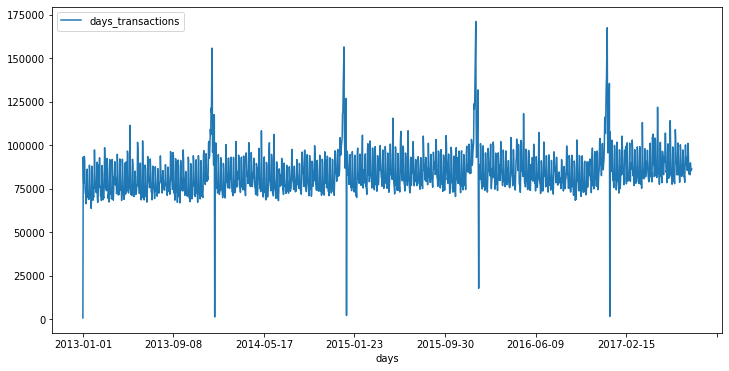

In [7]:
_,ax = plt.subplots(figsize=(12,6))
_=ts_df.plot(ax=ax)

In [8]:
#based on holiday EDA -- New Years has least transactions; this is one adjustment need to make

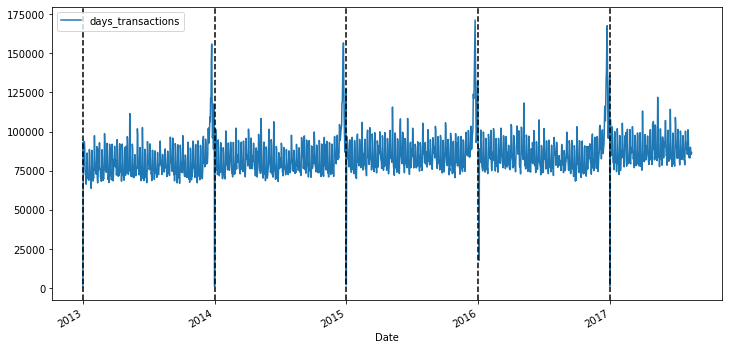

In [9]:
new_years =['2013-01-01', '2014-01-01','2015-01-01', '2016-01-01', '2017-01-01']
day_transactions_df['Date'] = pd.to_datetime(day_transactions_df['days'])
ax = day_transactions_df.plot(x='Date', y='days_transactions', figsize=(12,6))
for ny in new_years:
    plt.axvline(x=ny, color='black', linestyle='--')

In [10]:
#interested in what's going on overall in December as it appears to part from other months
#therefore bounding from 1 Dec to New Year

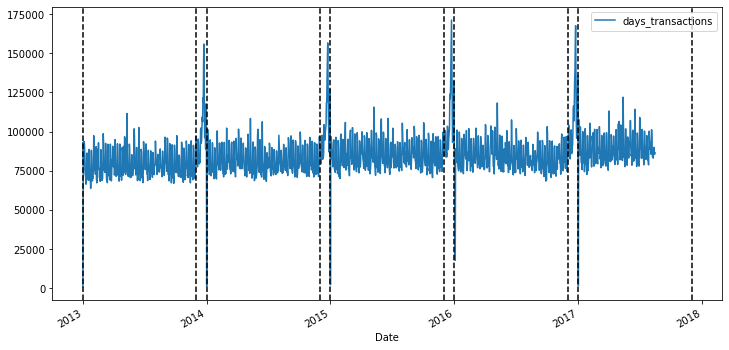

In [11]:
bounds = ['2013-12-01', '2013-01-01', '2014-12-01', '2014-01-01',
          '2015-12-01', '2015-01-01', '2016-12-01','2016-01-01', 
          '2017-12-01', '2017-01-01']

day_transactions_df['Date'] = pd.to_datetime(day_transactions_df['days'])
ax = day_transactions_df.plot(x='Date', y='days_transactions', figsize=(12,6)) 
for bound in bounds:
    plt.axvline(x=bound, color='black', linestyle='--')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Bounding transactions during the month of December shows
                                  significant increases in transactions per day until the New 
                                  Year when transactions drop to almost zero. It would be 
                                  worth zooming in during this month to get a better view. </span>
</div>

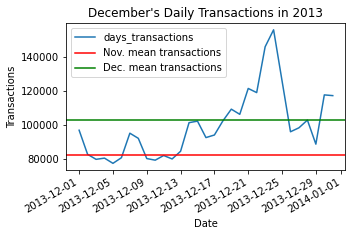

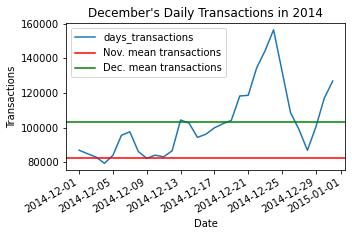

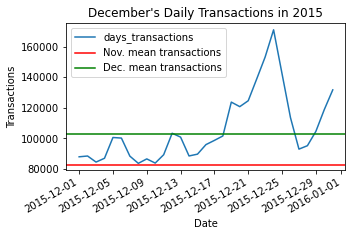

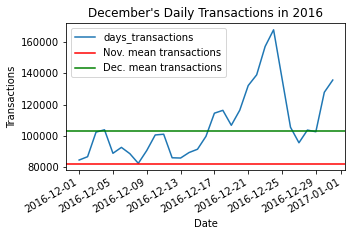

In [12]:
december = day_transactions_df[day_transactions_df.Date.dt.month == 12]
november = day_transactions_df[day_transactions_df.Date.dt.month == 11]
nov_mean = november.days_transactions.values.mean()
dec_mean = december.days_transactions.values.mean()
years = [2013, 2014, 2015, 2016]
for i, year in enumerate(years):
    temp=december[december.Date.dt.year == year]
    temp.plot(x='Date', y='days_transactions', figsize=(5,3), title=f"December's Daily Transactions in {str(year)}")
    plt.axhline(y = nov_mean, color = 'r', linestyle = '-', label='Nov. mean transactions')
    plt.axhline(y = dec_mean, color = 'g', linestyle = '-', label='Dec. mean transactions')
    plt.ylabel("Transactions")
    plt.legend(loc = 'upper left')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Transactions generally increase every day toward the end of December
                                  and crescendo around Christmas; plotting November could provide more
                                  insight</span>
</div>

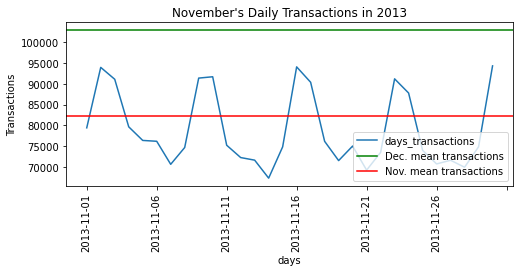

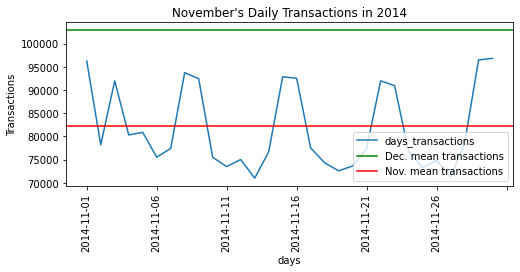

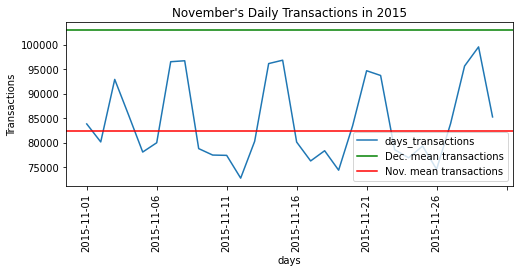

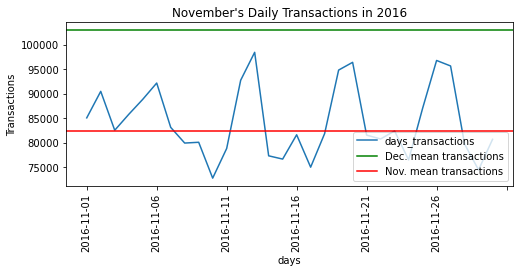

In [13]:
for i, year in enumerate(years):
    temp=november[november.Date.dt.year == year]
    temp.plot(x='days', y='days_transactions',figsize=(8,3), title=f"November's Daily Transactions in {str(year)}")
    plt.axhline(y = dec_mean, color = 'g', linestyle = '-', label='Dec. mean transactions')
    plt.axhline(y = nov_mean, color = 'r', linestyle = '-', label='Nov. mean transactions')
    plt.xticks(rotation=90)
    plt.ylabel("Transactions")
    plt.legend(loc = 'lower right')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> November also shows weekly peeks in the data, so it would be worth knowing which specific days those are to adjust for later</span>
</div>

In [14]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
            4:'Friday', 5:'Saturday', 6:'Sunday'}
x_axis = []
for date in december['Date']:
    x_axis.append(str(weekdays[date.weekday()]) + ' ' + str(date)[4:-len("00:00:00")])
december['Days of Week'] = x_axis

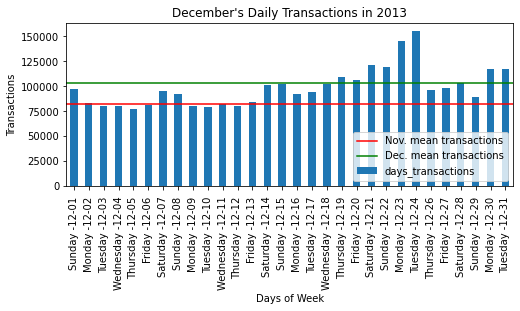

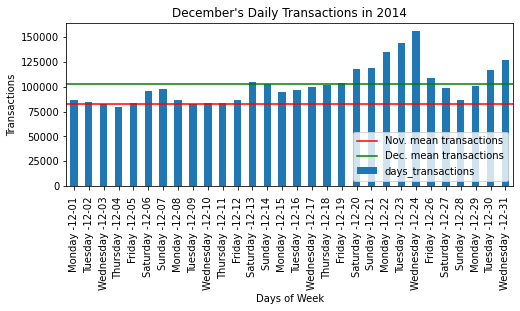

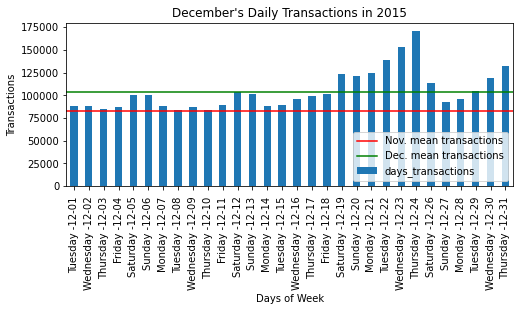

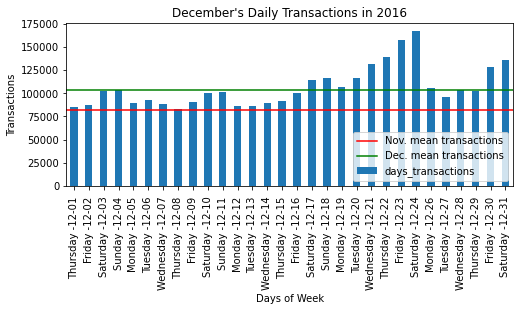

In [15]:
for i, year in enumerate(years):
    temp=december[december.Date.dt.year == year]
    temp.plot(kind='bar',x='Days of Week', y='days_transactions',figsize=(8,3), title=f"December's Daily Transactions in {str(year)}")
    plt.axhline(y = nov_mean, color = 'r', linestyle = '-', label='Nov. mean transactions')
    plt.axhline(y = dec_mean, color = 'g', linestyle = '-', label='Dec. mean transactions')
    plt.xticks(rotation=90)
    plt.ylabel("Transactions")
    plt.legend(loc = 'lower right')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Ecuadorians apparently do most of their shopping on Saturdays and Sundays.  For the next section, I want to take a "brute force" approach and adjust transactions based on observations from the plot. See the adjust function below. </span>
</div>

In [16]:
def adjust(d, value):
    
    #overall 5 percent decrease of values in Dec
    value = value - (value * .05)
    
    #dictionary object for holding values to adjust each day by
    adjust_for = {}
    
    #experimenting with 5 percent increase from 19 to 26 Dec
    for day, p in zip(range(19,26), np.arange(.2,.55, .05)):
        adjust_for[day] = p
    
    #adjusting for similar values on 20/21 Dec
    adjust_for[30] = .25
    adjust_for[31] = .30
    
    return value - (value * adjust_for.get(d.day, 0))

In [17]:
december['adjusted_transactions'] = [adjust(d, value) for d, value in zip(december['Date'], december['days_transactions'])]

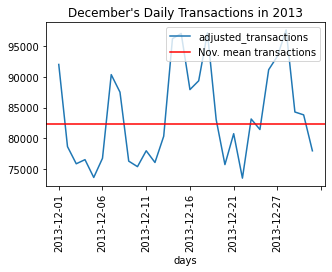

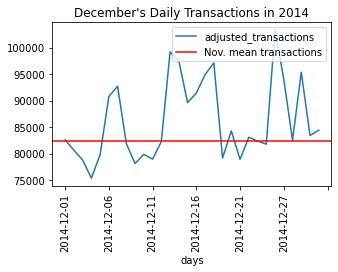

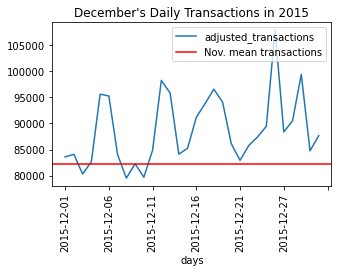

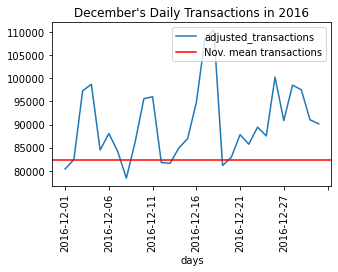

In [18]:
years = [2013, 2014, 2015, 2016]
for i, year in enumerate(years):
    temp=december[december.Date.dt.year == year]
    temp.plot(x='days', y='adjusted_transactions',figsize=(5,3), title=f"December's Daily Transactions in {str(year)}")
    plt.axhline(y = nov_mean, color = 'r', linestyle = '-', label='Nov. mean transactions')
    plt.legend(loc = 'upper right')
    plt.xticks(rotation=90)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Based on the plots above, the "brute force" method of adjusting the 
                                  transactions in December could be improved, but for sake of advancing
                                  exploration---now going to adjust New Year dates with lowest
                                  transactions </span>
</div>

In [19]:
diff = dec_mean - nov_mean
def adjustbydate(date, value):
    if date in ['2013-01-01', '2014-01-01','2015-01-01', '2016-01-01','2016-01-04', '2017-01-01']:
        return diff*4
    if date in december.days.values:
        return int(december[december.days == date].adjusted_transactions.values[0])
    else:
        return value

In [20]:
day_transactions_df['adjusted'] = [adjustbydate(date, value) for date, value in zip(day_transactions_df['days'], day_transactions_df['days_transactions'])]

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> After plotting below--- it's apparent that additional transactions/dates need
                                  to be adjusted for. Based on the the Holiday EDA of this project, it appears
                                  that mother's day results in high transactions. So adjusting for this below </span>
</div>

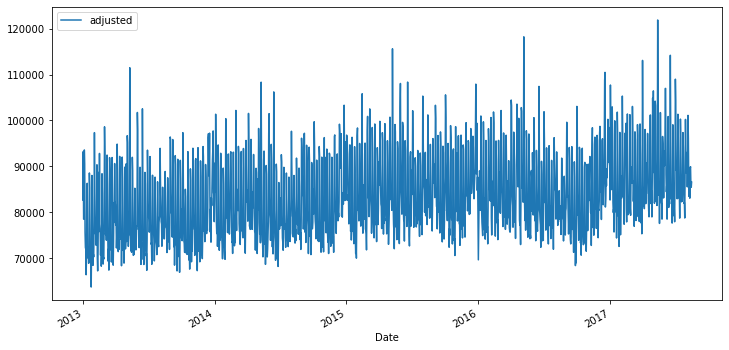

In [21]:
day_transactions_df['Date'] = pd.to_datetime(day_transactions_df['days'])
ax = day_transactions_df.plot(x='Date', y='adjusted', figsize=(12,6))

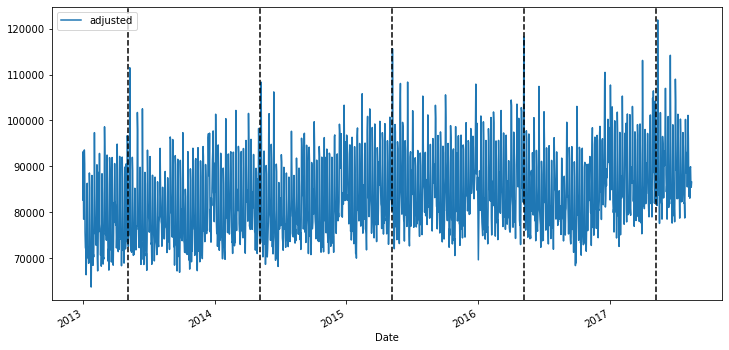

In [22]:
day_transactions_df['Date'] = pd.to_datetime(day_transactions_df['days'])
ax = day_transactions_df.plot(x='Date', y='adjusted', figsize=(12,6))
xcoords = ['2013-05-07', '2014-05-07', '2015-05-07', '2016-05-07',
           '2017-05-07']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

In [23]:
def adjust_again(d, value):
    xcoords = ['2013-05-11',
               '2014-05-10',
               '2015-05-09',
               '2016-05-07',
               '2017-05-13']
    if d in xcoords:
        return value - (value * .30)
    else:
        return value

In [24]:
day_transactions_df['adjusted_again'] = [ adjust_again(d, value) for d, value in zip(day_transactions_df['days'], day_transactions_df['adjusted'])]

In [25]:
#maxt = day_transactions_df[day_transactions_df.Date.dt.year==2013]['adjusted'].max()
#day_transactions_df[day_transactions_df.adjusted == maxt]

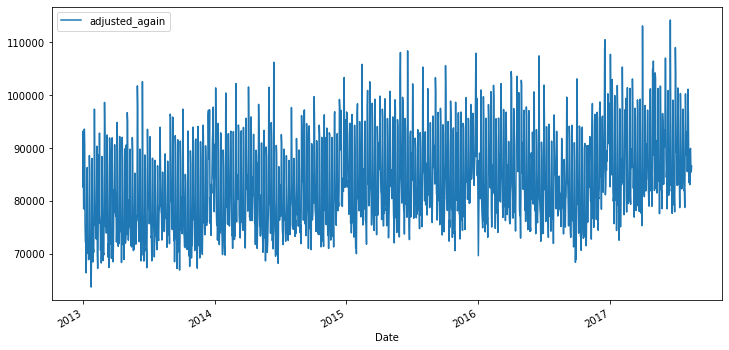

In [26]:
ax = day_transactions_df.plot(x='Date', y='adjusted_again', figsize=(12,6))
xcoords = ['2013-05-07','2013-05-08',
           '2014-05-07', '2014-05-08',
           '2015-05-07', '2015-05-08',
           '2016-05-07', '2016-05-08',
           '2017-05-07', '2017-05-08']
#for xc in xcoords:
#    plt.axvline(x=xc, color='black', linestyle='--')

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> It appears more adjustments need to be made but for the sake of
                                  advancing the project, now going to explore Dr. Elston's suggestion
                                  that we remove the trend, which generally appears to be heading
                                  in a positive direction. To do this, I want to see a scatter plot of
                                  the data and then fit a simple linear regression model, which I will
                                  use as my "trend" that I need to remove. </span>
</div>

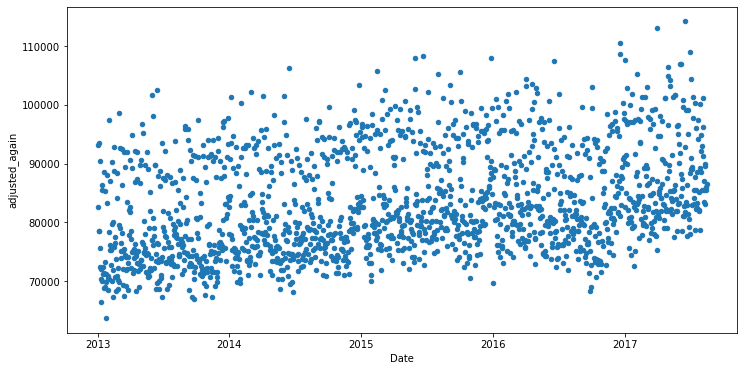

In [27]:
_=day_transactions_df.plot(kind='scatter', x='Date', y='adjusted_again', figsize=(12,6))

In [28]:
baseDF = day_transactions_df[['Date',  'adjusted_again']].copy()
baseDF.rename(columns={'Date':'date', 'adjusted_again': 'transactions'}, inplace=True)
baseDF.set_index('date', inplace=True)
t_times = len(baseDF.index)
baseDF['time_t'] = np.arange(t_times)
time_t = baseDF.loc[:, ['time_t']]
y = baseDF.loc[:, 'transactions']
y, time_t = y.align(time_t, join='inner') 

In [29]:
#Fit Linear Regression Model
reg = LinearRegression().fit(time_t, y)
trend = pd.Series(reg.predict(time_t), index=time_t.index)

In [30]:
y

date
2013-01-01    82664.5
2013-01-02    93215.0
2013-01-03    78504.0
2013-01-04    78494.0
2013-01-05    93573.0
               ...   
2017-08-11    89551.0
2017-08-12    89927.0
2017-08-13    85993.0
2017-08-14    85448.0
2017-08-15    86561.0
Name: transactions, Length: 1682, dtype: float64

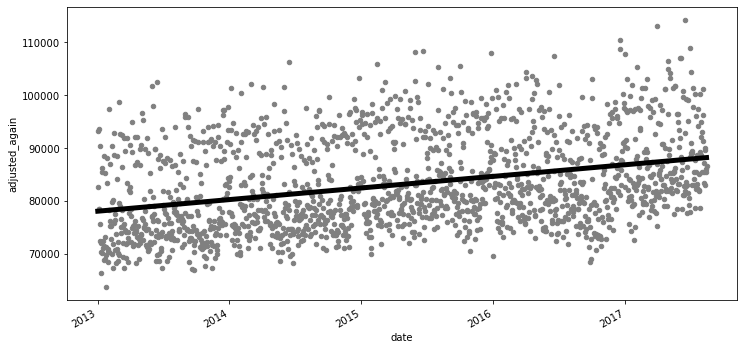

In [31]:
ax=day_transactions_df.plot(kind='scatter', x='Date', y='adjusted_again', figsize=(12,6), color="grey")
_ = trend.plot(color="black", ax = ax,lw=5)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Now that I have the trend data, I'd like to subtract it from the original,
                                  which I do and plot below </span>
</div>

In [32]:
y_untrended = y - trend
y_untrended = pd.DataFrame(y_untrended)
y_untrended.rename(columns={0:'transactions'}, inplace=True)

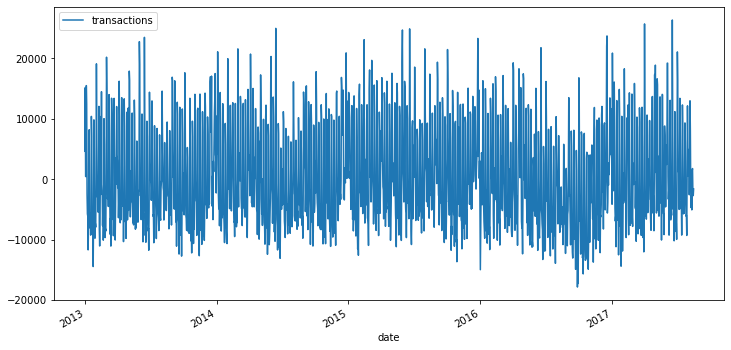

In [33]:
_=y_untrended.plot(figsize=(12,6))

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> Decomposing the information should show a straight line for the trend, 
                                  which I look at below. Additional adjustment work is needed...</span>
</div>

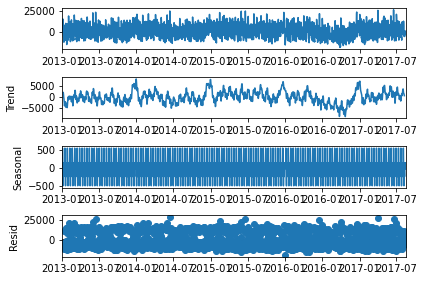

In [34]:
def decomp_ts(ts, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period=12) 
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                          index = ts.index) )

decomp = decomp_ts(y_untrended, model='additive')

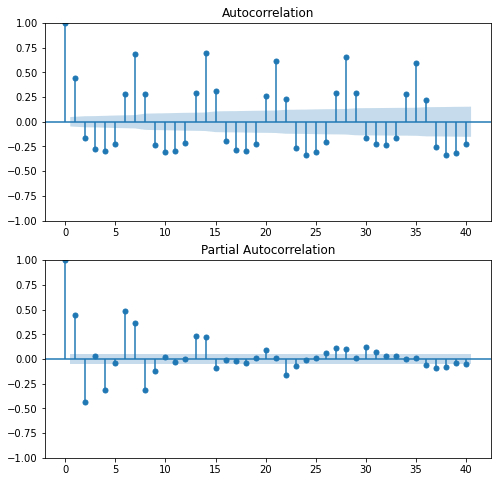

In [35]:
def auto_partial_corr_plot(ts):
    _,ax = plt.subplots(2,1, figsize=(8,8))
    _=splt.plot_acf(ts, lags = 40, ax=ax[0]);
    _=splt.plot_pacf(ts, lags = 40, method='yw', ax=ax[1]);

auto_partial_corr_plot(y_untrended)

         Values                       Metric
0 -7.445966e+00               D-F Statistics
1  5.837426e-11                      p-value
2  2.200000e+01          number of lags used
3  1.659000e+03  Number of observations used
4 -3.434298e+00          critical value (1%)
5 -2.863284e+00          critical value (5%)
6 -2.567698e+00         critical value (10%)


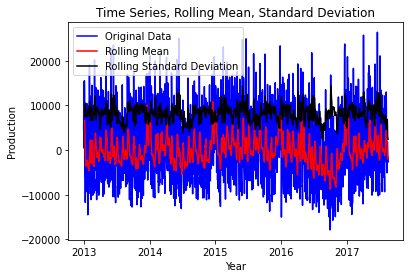

In [36]:
def test_stationarity(df):
    
    # Plot rolling mean and std
    rolling_mean = df.rolling(7).mean()
    rolling_std = df.rolling(7).std()
    
    plt.plot(df, color="blue",label="Original Data")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation")
    plt.xlabel('Year')
    plt.ylabel('Production')
    plt.title("Time Series, Rolling Mean, Standard Deviation")
    plt.legend(loc="best")
    
    # use the augmented Dickey-Fuller test from the statsmodels package. 
    adft = adfuller(df,autolag='BIC')

    output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  ,
                              "Metric":["D-F Statistics","p-value","number of lags used","Number of observations used",
                              "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return print(output_df)
test_stationarity(y_untrended)

<div style="background-color:#EEB89F">
    <span style="font-size:40px"> COMMENTARY  </span> 
    </br>
    <span style="font-size:20px"> The p-value resulting from the Augmented Dickey-Fuller test
                                  is very low showing that the time series is stationary. The
                                  critical values at 1,5,and 10 percent confidence intervals
                                  are relatively close to the test statistic. Based on the PACF, I see
                                  8 significant coeficients, so as a test am going to create a model
                            </span>
</div>

In [37]:
def model_ARIMA(ts, order):
    model = ARIMA(ts, order=order)
 #   model_fit = model.fit(disp=0, method='mle', trend='nc')
    model_fit = model.fit()
    print(model_fit.summary())
    return(model_fit)
model = model_ARIMA(y_untrended, order = (8,0,0))

                               SARIMAX Results                                
Dep. Variable:           transactions   No. Observations:                 1682
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -16694.955
Date:                Sat, 26 Nov 2022   AIC                          33409.910
Time:                        17:24:52   BIC                          33464.188
Sample:                             0   HQIC                         33430.015
                               - 1682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.653e-06    288.601   5.73e-09      1.000    -565.648     565.648
ar.L1          0.6010      0.019     31.447      0.000       0.564       0.638
ar.L2         -0.2553      0.020    -12.864      0.0

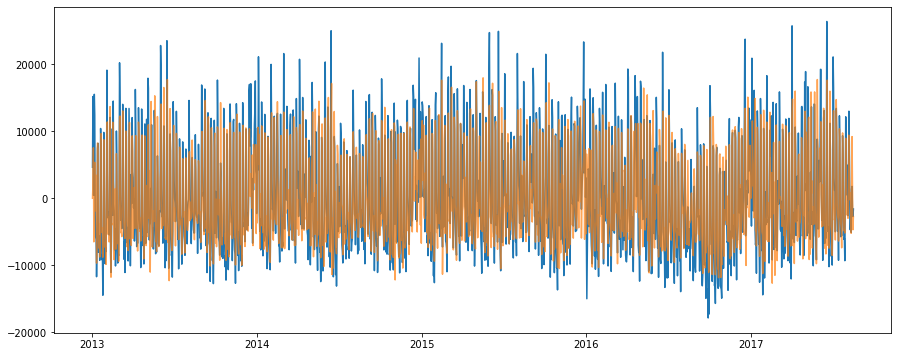

In [39]:
plt.figure(figsize=(15,6))
plt.subplot
plt.plot(y_untrended);
plt.plot(model.fittedvalues,alpha=.7);